In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("./")

import pandas as pd
import os
import seaborn as sns
from datetime import timedelta

from utils.date_filter import DATE_RANGE, filter_dates

## Step 1: Filter out potential depression candidates

**Heuristics**
* High pss-4 score (mean) [weight: 1]
* High pss-4 variance (standard deviation) [weight: 0, does not seem to be a good indicator]
* Filled out the pss-4 form at least 3 times
* Latest data (W_4/2021 data in GLOBEM dataset)

In [2]:
# load INS-W_4 dataset for evaluation
def load_single_file_csv(data_path, folder_path, file_name, pids_filter=None): 
    survey_data_dir = os.path.join(data_path, folder_path, file_name)
    df = pd.read_csv(survey_data_dir)
    if pids_filter is not None:
        return df[df['pid'].isin(pids_filter)]
    else:
        return df

def min_max_standardize(df, column_name):
    df[column_name] = (df[column_name] - df[column_name].min()) / (
        df[column_name].max() - df[column_name].min())
    return df

In [3]:
dep_weekly_new = load_single_file_csv("data_raw/INS-W_4/", "SurveyData", "ema.csv")
# print(dep_weekly_new.head())
dep_weekly_new = filter_dates(dep_weekly_new, DATE_RANGE[4]["start"], DATE_RANGE[4]["end"])

# calculate the mean of each pid
dep_weekly_new_mean = dep_weekly_new.groupby(
    "pid")['pss4_EMA'].mean().reset_index().rename(columns={'pss4_EMA': 'dep_mean'})

# calculate the standard deviation of each pid
dep_weekly_new_std = dep_weekly_new.groupby(
    "pid")['pss4_EMA'].std().reset_index().rename(columns={'pss4_EMA': 'dep_std'})

# merge the two dataframes on 'pid'
dep_weekly_mean_std = pd.merge(
    dep_weekly_new_mean, dep_weekly_new_std, on='pid', how='inner')

dep_weekly_mean_std.head()

pid  dep_mean   dep_std
0  INS-W_1000       5.4  1.505545
1  INS-W_1001       7.4  1.349897
2  INS-W_1002       3.6  0.966092
3  INS-W_1003       4.8  1.932184
4  INS-W_1004       6.7  1.337494

In [4]:
dep_weekly_mean_std = min_max_standardize(dep_weekly_mean_std, 'dep_mean')
dep_weekly_mean_std = min_max_standardize(dep_weekly_mean_std, 'dep_std')
dep_weekly_mean_std.head()

pid  dep_mean   dep_std
0  INS-W_1000  0.400000  0.318579
1  INS-W_1001  0.548148  0.285643
2  INS-W_1002  0.266667  0.204429
3  INS-W_1003  0.355556  0.408857
4  INS-W_1004  0.496296  0.283019

In [5]:
# add another column, the sum of phq4_mean and phq4_std
dep_weekly_mean_std['dep_score'] = 1 * dep_weekly_mean_std['dep_mean'] + 0 * dep_weekly_mean_std['dep_std']
# sort by phq4_sum column
dep_weekly_mean_std = dep_weekly_mean_std.sort_values(by="dep_score", ascending=False)
dep_weekly_mean_std.head(n = 10)

pid  dep_mean   dep_std  dep_score
107  INS-W_1222  1.000000  0.491216   1.000000
75   INS-W_1077  0.925926  0.363099   0.925926
88   INS-W_1202  0.903704  0.486637   0.903704
64   INS-W_1065  0.822222  0.253336   0.822222
98   INS-W_1213  0.822222  0.610440   0.822222
101  INS-W_1216  0.804233  0.309756   0.804233
27   INS-W_1027  0.790123  0.461180   0.790123
5    INS-W_1005  0.785185  0.425552   0.785185
20   INS-W_1020  0.777778  0.277054   0.777778
164   INS-W_955  0.773663  0.282138   0.773663

In [6]:
# get top 10 pids
top_10_pids = dep_weekly_mean_std.head(10)['pid'].to_list()
print(top_10_pids)

# Criteria: reported at least 3 phq-4 scores
valid_pids = dep_weekly_new.groupby('pid').filter(
    lambda x: x['pss4_EMA'].notna().sum() > 3)['pid'].unique()

# set intersection
valid_pids = list(set(top_10_pids).intersection(set(valid_pids)))
print(valid_pids)

['INS-W_1222', 'INS-W_1077', 'INS-W_1202', 'INS-W_1065', 'INS-W_1213', 'INS-W_1216', 'INS-W_1027', 'INS-W_1005', 'INS-W_1020', 'INS-W_955']
['INS-W_1222', 'INS-W_1020', 'INS-W_1077', 'INS-W_1202', 'INS-W_1216', 'INS-W_1027', 'INS-W_955', 'INS-W_1065', 'INS-W_1005', 'INS-W_1213']


<Axes: xlabel='date', ylabel='pss4_EMA'>

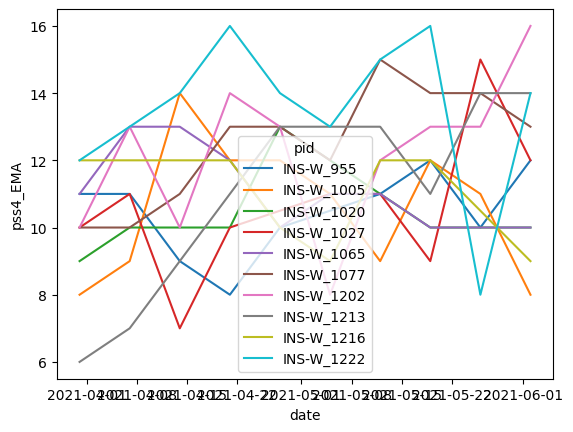

In [7]:
# slice valid_pids in dep_weekly_new
valid_pids_deps = dep_weekly_new[dep_weekly_new['pid'].isin(valid_pids)]
# visualize phq4 score, x is date, y is phq4, label pid, use sns
sns.lineplot(data=valid_pids_deps, x='date', y='pss4_EMA', hue='pid')

*Note: No interpolation! Self-report data (active data) requires human participation, i.e., should not be interpreted as data missing at random.*

In [8]:
valid_pids_deps.head()
# rename (strip _EMA for each column name)
valid_pids_deps.columns = valid_pids_deps.columns.str.replace('_EMA', '')

# store as INS-W_4_survey.csv
valid_pids_deps.to_csv("data_processed/INS-W_4_survey.csv", index=False)

## Step 2: Extract passive sensing data for the selected participants

**Heuristics**
* Do data transformation to derive human-interpretable, meaningful features
* Use the lowest granularity of data possible (e.g., hourly, parts of day, daily)

In [17]:
from utils.feature_loader import PassiveFeatureLoader
from utils.feature_loader_allday import PassiveFeatureLoaderAllDay
from utils.plot_feature import plot_feature

6 ['pid', 'date', 'f_wifi:phone_wifi_connected_rapids_uniquedevices:afternoon', 'f_wifi:phone_wifi_connected_rapids_uniquedevices:evening', 'f_wifi:phone_wifi_connected_rapids_uniquedevices:morning', 'f_wifi:phone_wifi_connected_rapids_uniquedevices:night']


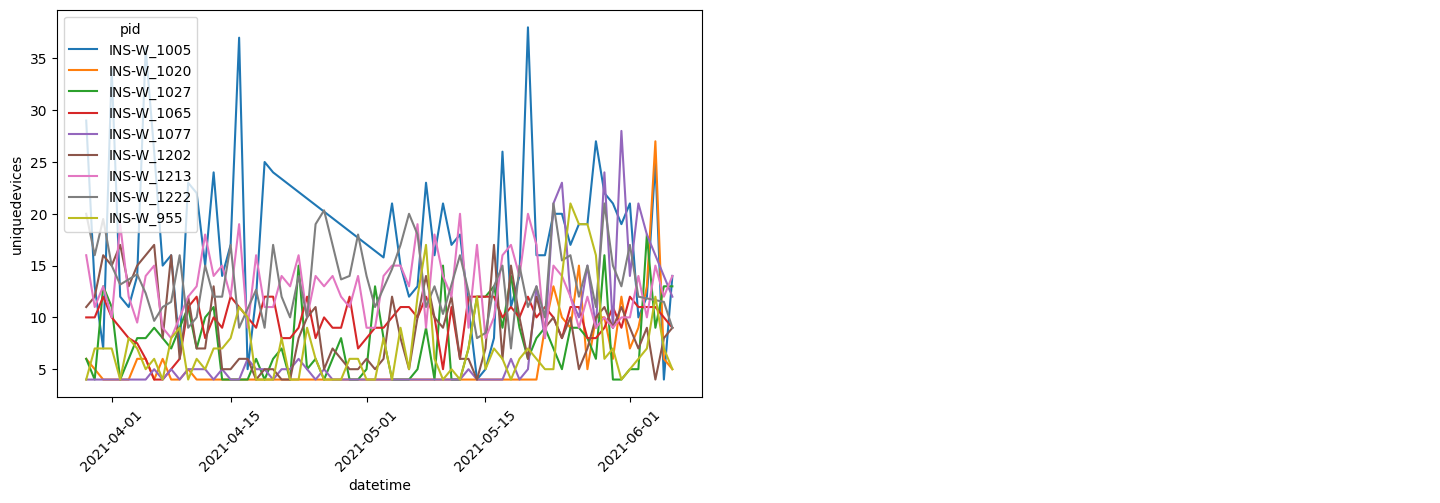

In [10]:
# wifiExtractFeatures = ["countscans", "uniquedevices", "countscansmostuniquedevice"]
wifiExtractFeatures = [
    # "countscans", 
    "uniquedevices"
    ]

wifiData = PassiveFeatureLoader("4", "wifi", 
                                wifiExtractFeatures, valid_pids)
plot_feature(wifiData)
wifiData.save_data()

6 ['pid', 'date', 'f_blue:phone_bluetooth_rapids_uniquedevices:afternoon', 'f_blue:phone_bluetooth_rapids_uniquedevices:evening', 'f_blue:phone_bluetooth_rapids_uniquedevices:morning', 'f_blue:phone_bluetooth_rapids_uniquedevices:night']


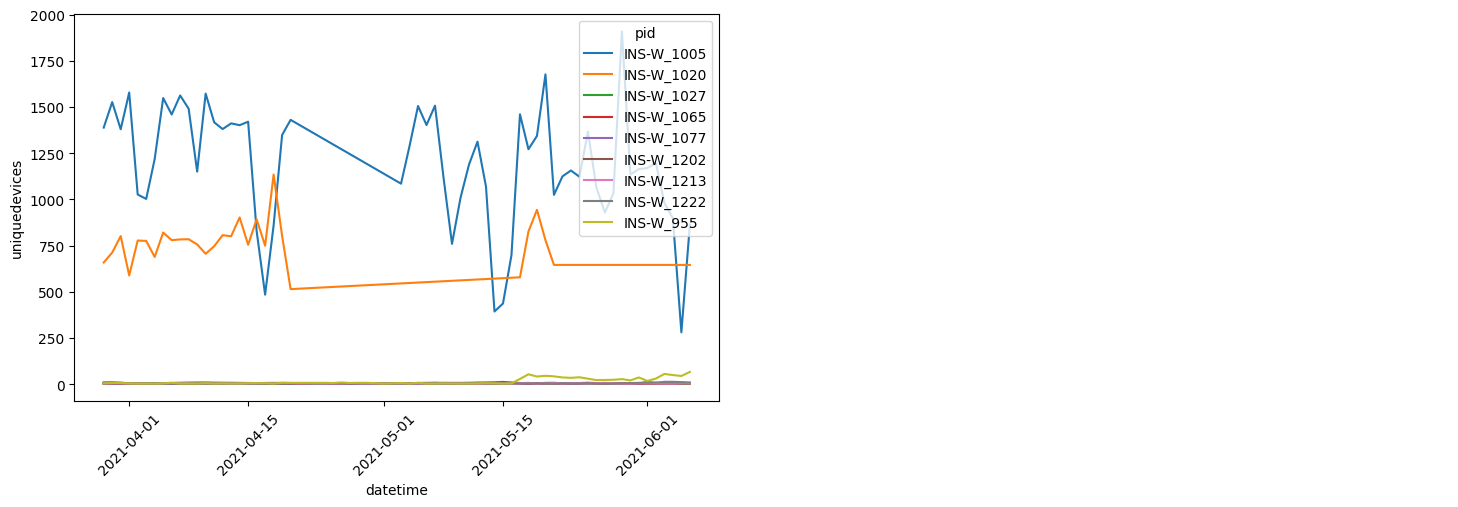

In [11]:
# bluetoothFeaturesToExtract = [
#     "countscans",
#     "uniquedevices",
#     "meanscansall",
#     "countscansmostfrequentdevicewithinsegmentsall",
#     "countscansleastfrequentdevicewithinsegmentsall",
#     "countscansmostfrequentdeviceacrosssegmentsall",
#     "countscansleastfrequentdeviceacrosssegmentsall",
#     "countscansmostfrequentdeviceacrossdatasetall",
#     "countscansleastfrequentdeviceacrossdatasetall"
# ]

bluetoothFeaturesToExtract = [
    # "countscans",
    "uniquedevices",
    # "meanscansall",
    # "countscansmostfrequentdevicewithinsegmentsall",
    # "countscansmostfrequentdeviceacrosssegmentsall",
    # "stdscansall",
    # "countscansmostfrequentdeviceacrossdatasetall"
]

allBluetoothData = PassiveFeatureLoader(
    "4", "bluetooth", bluetoothFeaturesToExtract, valid_pids)
plot_feature(allBluetoothData)
allBluetoothData.save_data()

3
14 ['pid', 'date', 'f_steps:fitbit_steps_intraday_rapids_sumsteps:afternoon', 'f_steps:fitbit_steps_intraday_rapids_avgsteps:afternoon', 'f_steps:fitbit_steps_intraday_rapids_countepisodesedentarybout:afternoon', 'f_steps:fitbit_steps_intraday_rapids_sumsteps:evening', 'f_steps:fitbit_steps_intraday_rapids_avgsteps:evening', 'f_steps:fitbit_steps_intraday_rapids_countepisodesedentarybout:evening', 'f_steps:fitbit_steps_intraday_rapids_sumsteps:morning', 'f_steps:fitbit_steps_intraday_rapids_avgsteps:morning', 'f_steps:fitbit_steps_intraday_rapids_countepisodesedentarybout:morning', 'f_steps:fitbit_steps_intraday_rapids_sumsteps:night', 'f_steps:fitbit_steps_intraday_rapids_avgsteps:night', 'f_steps:fitbit_steps_intraday_rapids_countepisodesedentarybout:night']


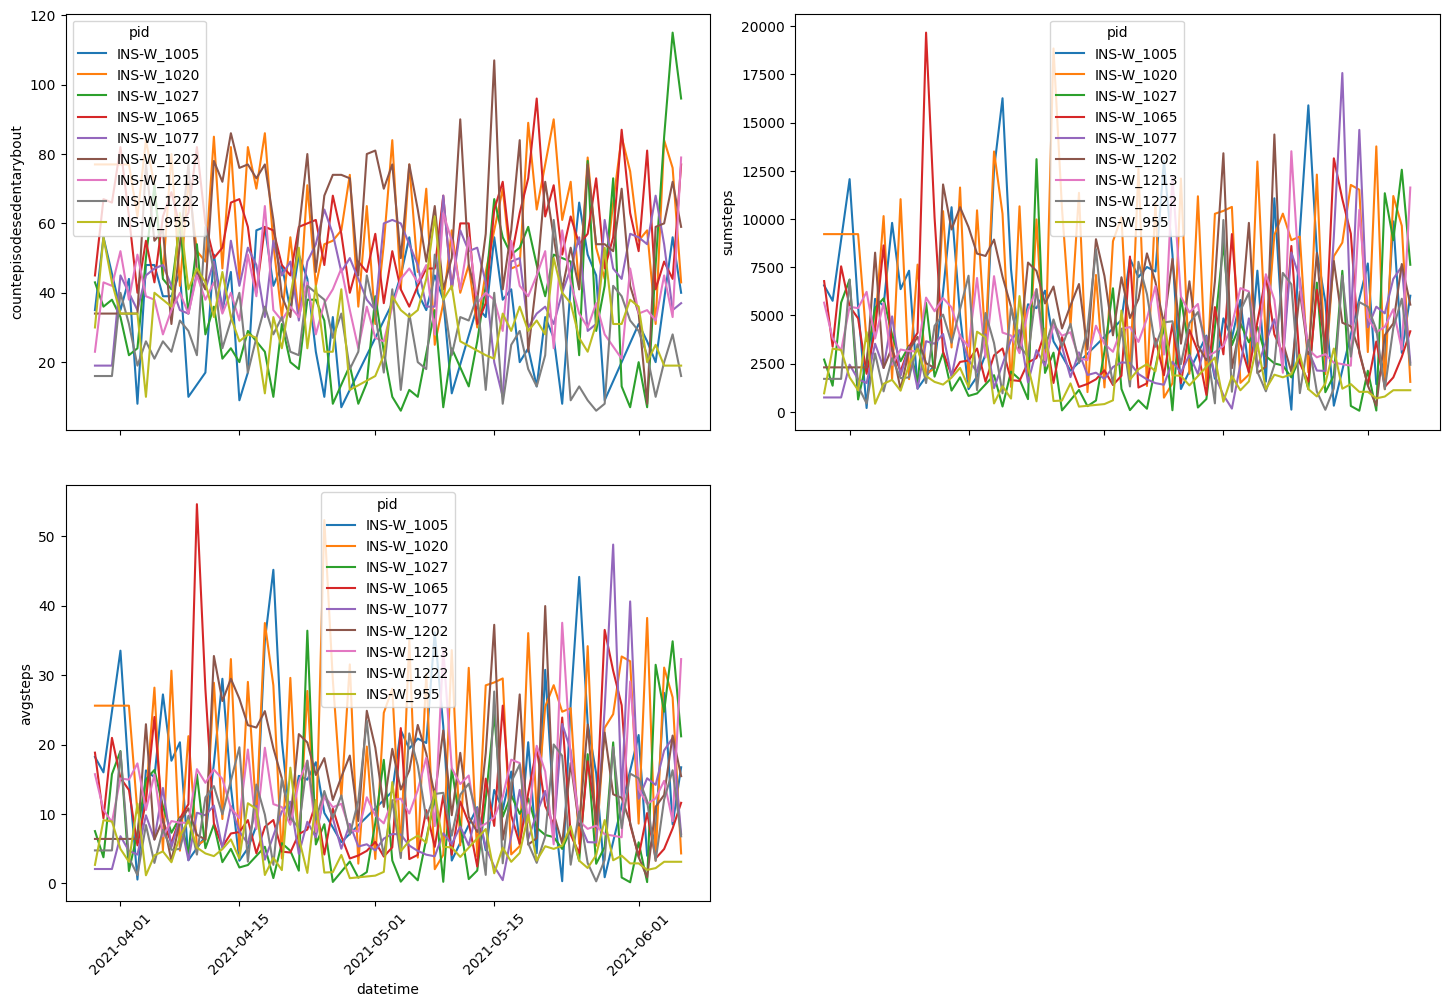

In [12]:
# physicalActivityFeaturesToExtract = [
#     "maxsumsteps",
#     "minsumsteps",
#     "avgsumsteps",
#     "mediansumsteps",
#     "stdsumsteps",
#     "sumsteps",
#     "maxsteps",
#     "minsteps",
#     "avgsteps",
#     "stdsteps",
#     "countepisodesedentarybout",
#     "sumdurationsedentarybout",
#     "maxdurationsedentarybout",
#     "mindurationsedentarybout",
#     "avgdurationsedentarybout",
#     "stddurationsedentarybout",
#     "countepisodeactivebout",
#     "sumdurationactivebout",
#     "maxdurationactivebout",
#     "mindurationactivebout",
#     "avgdurationactivebout",
#     "stddurationactivebout"
# ]

# sumsteps does not exsist on the granular we are focusing on
physicalActivityFeaturesToExtract = [
    "countepisodesedentarybout",
    # "sumdurationsedentarybout",
    "sumsteps",
    # "avgdurationactivebout",
    # "countepisodeactivebout",
    # "maxdurationsedentarybout",
    # "sumdurationactivebout",
    "avgsteps",
    # "avgdurationsedentarybout",
    # "maxdurationactivebout",
]

print(len(physicalActivityFeaturesToExtract))

allPhysicalActivityData = PassiveFeatureLoader(
    "4", "steps", physicalActivityFeaturesToExtract, valid_pids)
plot_feature(allPhysicalActivityData)
allPhysicalActivityData.save_data()

30 ['pid', 'date', 'f_loc:phone_locations_doryab_numberofsignificantplaces:afternoon', 'f_loc:phone_locations_doryab_radiusgyration:afternoon', 'f_loc:phone_locations_doryab_timeathome:afternoon', 'f_loc:phone_locations_doryab_totaldistance:afternoon', 'f_loc:phone_locations_locmap_duration_in_locmap_study:afternoon', 'f_loc:phone_locations_locmap_duration_in_locmap_exercise:afternoon', 'f_loc:phone_locations_locmap_duration_in_locmap_greens:afternoon', 'f_loc:phone_locations_doryab_numberofsignificantplaces:evening', 'f_loc:phone_locations_doryab_radiusgyration:evening', 'f_loc:phone_locations_doryab_timeathome:evening', 'f_loc:phone_locations_doryab_totaldistance:evening', 'f_loc:phone_locations_locmap_duration_in_locmap_study:evening', 'f_loc:phone_locations_locmap_duration_in_locmap_exercise:evening', 'f_loc:phone_locations_locmap_duration_in_locmap_greens:evening', 'f_loc:phone_locations_doryab_numberofsignificantplaces:morning', 'f_loc:phone_locations_doryab_radiusgyration:mornin

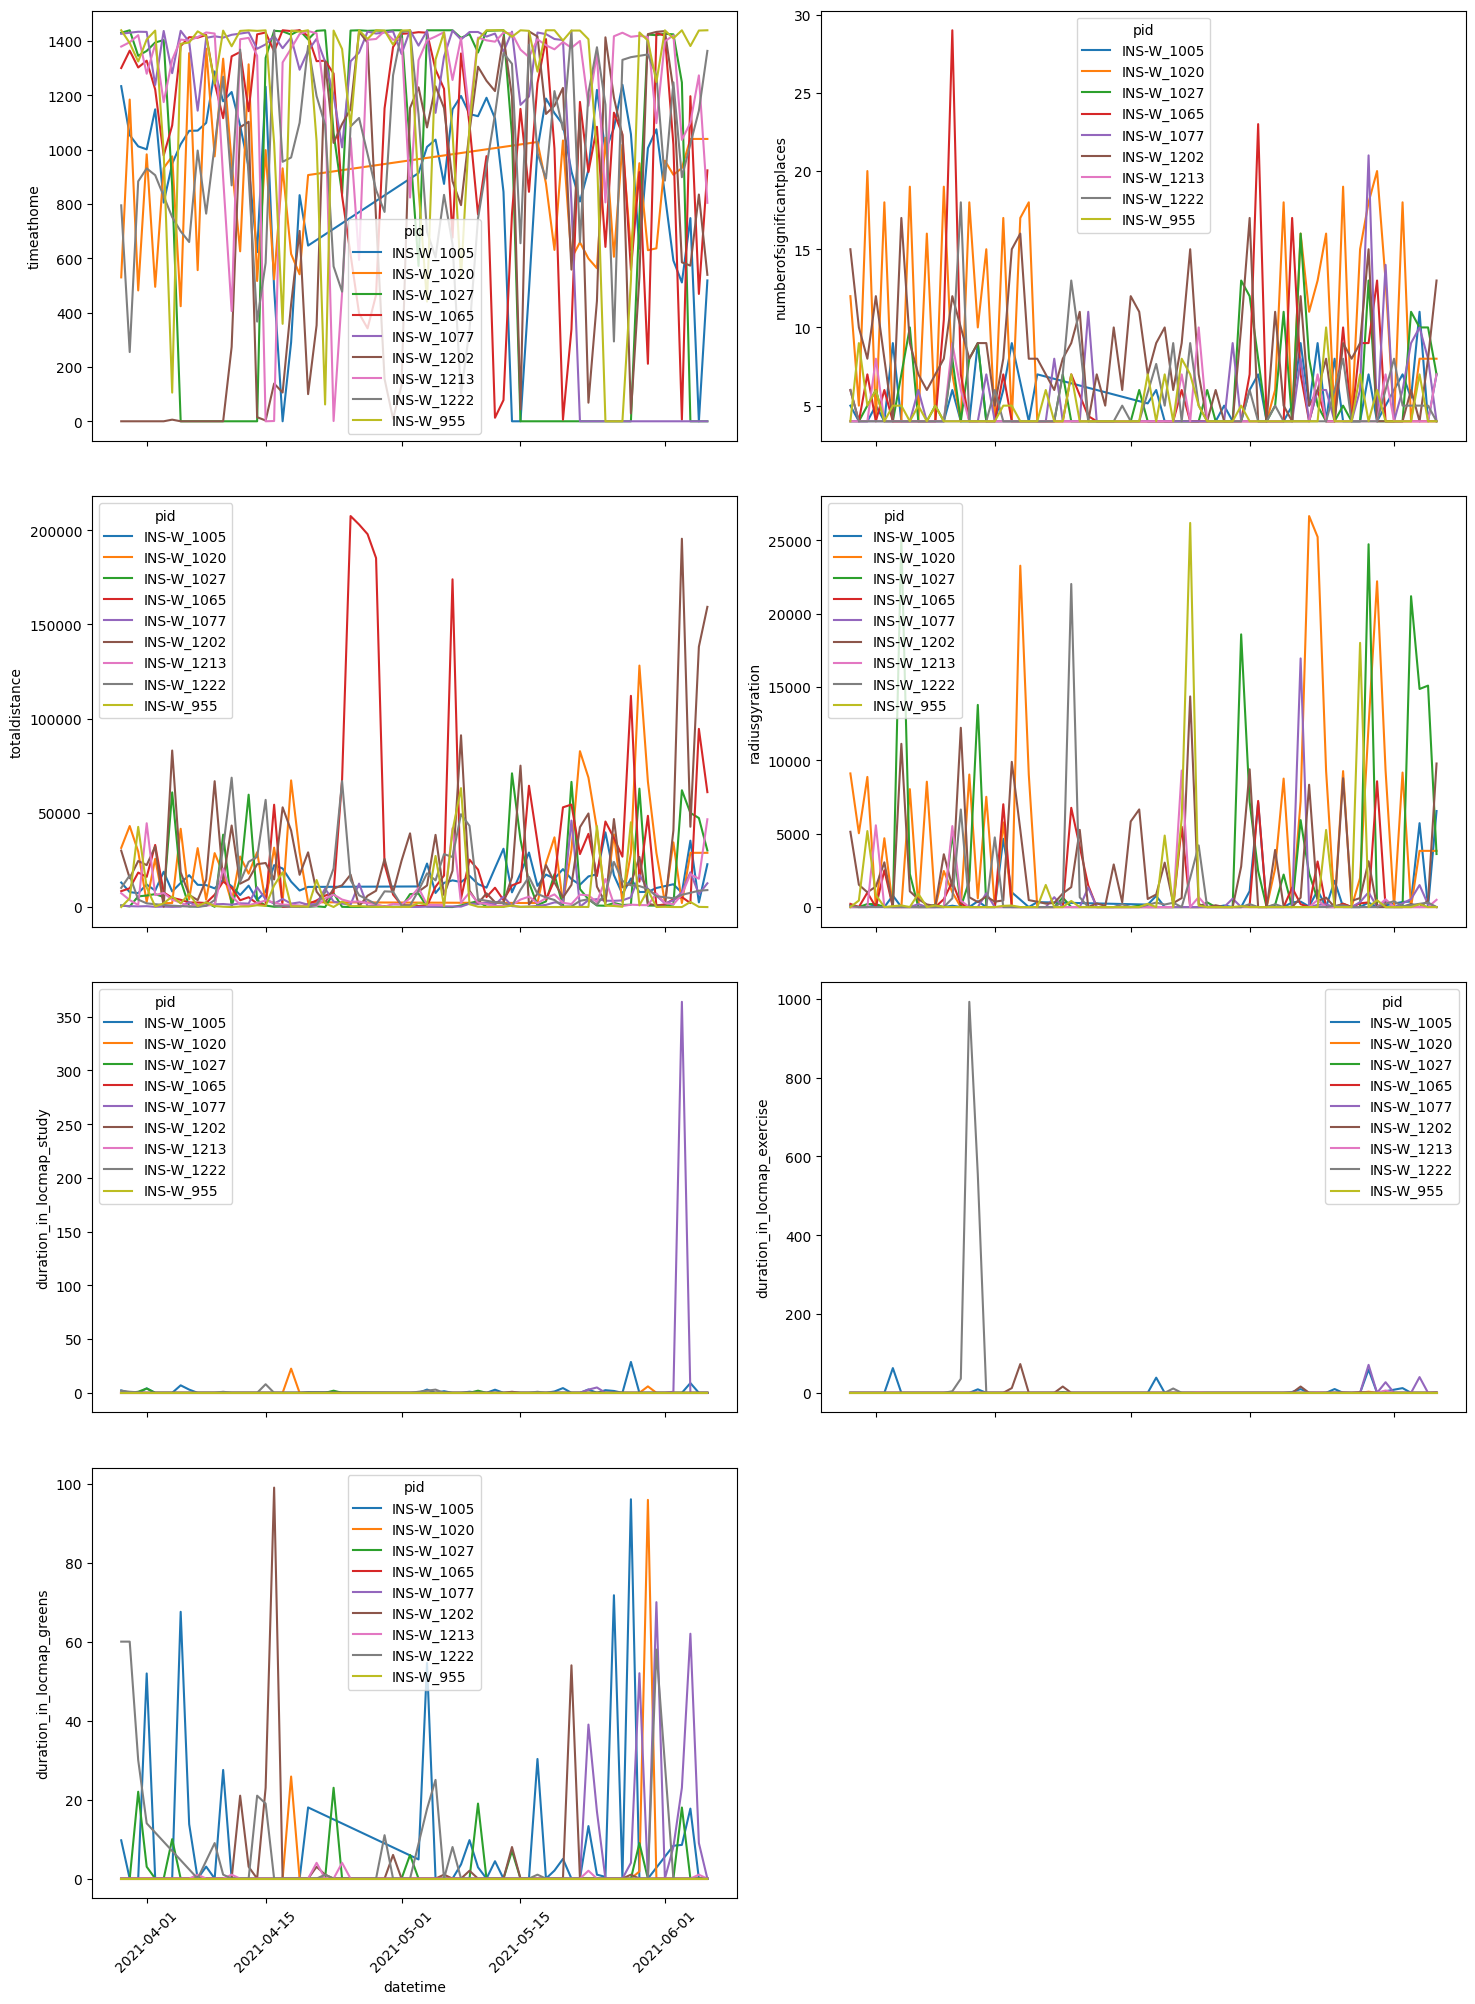

In [13]:
# locationFeaturesToExtract = [
#     "avgflightdur",
#     "avgflightlen",
#     "circdnrtn",
#     "disttravelled",
#     "hometime",
#     "maxdiam",
#     "maxhomedist",
#     "probpause",
#     "rog",
#     "siglocentropy",
#     "siglocsvisited",
#     "stdflightdur",
#     "stdflightlen",
#     "wkenddayrtn",
#     "avglengthstayatclusters",
#     "avgspeed",
#     "homelabel",
#     "locationentropy",
#     "locationvariance",
#     "loglocationvariance",
#     "maxlengthstayatclusters",
#     "minlengthstayatclusters",
#     "movingtostaticratio",
#     "normalizedlocationentropy",
#     "numberlocationtransitions",
#     "numberofsignificantplaces",
#     "outlierstimepercent",
#     "radiusgyration",
#     "stdlengthstayatclusters",
#     "timeathome",
#     "timeattop1location",
#     "timeattop2location",
#     "timeattop3location",
#     "totaldistance",
#     "varspeed",
#     "duration_in_locmap_study",
#     "percent_in_locmap_study",
#     "duration_in_locmap_exercise",
#     "percent_in_locmap_exercise",
#     "duration_in_locmap_greens",
#     "percent_in_locmap_greens"
# ]

locationFeaturesToExtract = [
    "timeathome",  # "duration_in_locmap_living",
    "numberofsignificantplaces",
    "totaldistance",
    "radiusgyration", # TODO: do we want this
    # "locationentropy",
    "duration_in_locmap_study",
    "duration_in_locmap_exercise",
    "duration_in_locmap_greens",    
    # "numberlocationtransitions",
    # "timeattop1location",
    # "timeattop2location",
    # "timeattop3location",
    # "movingtostaticratio",
    # "maxlengthstayatclusters",
    # "avglengthstayatclusters",
    # "normalizedlocationentropy"
]


allLocationData = PassiveFeatureLoader(
    "4", "location", locationFeaturesToExtract, valid_pids)
plot_feature(allLocationData)
allLocationData.save_data()

34 ['pid', 'date', 'f_slp:fitbit_sleep_intraday_rapids_avgdurationasleepunifiedmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_avgdurationawakeunifiedmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_maxdurationawakeunifiedmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_sumdurationawakeunifiedmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeasleepunifiedmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_countepisodeawakeunifiedmain:afternoon', 'f_slp:fitbit_sleep_intraday_rapids_avgdurationasleepunifiedmain:evening', 'f_slp:fitbit_sleep_intraday_rapids_avgdurationawakeunifiedmain:evening', 'f_slp:fitbit_sleep_intraday_rapids_maxdurationasleepunifiedmain:evening', 'f_slp:fitbit_sleep_intraday_rapids_maxdurationawakeunifiedmain:evening', 'f_slp:fitbit_sleep_intraday_rapids_sumdurationasleepunifiedmain:even

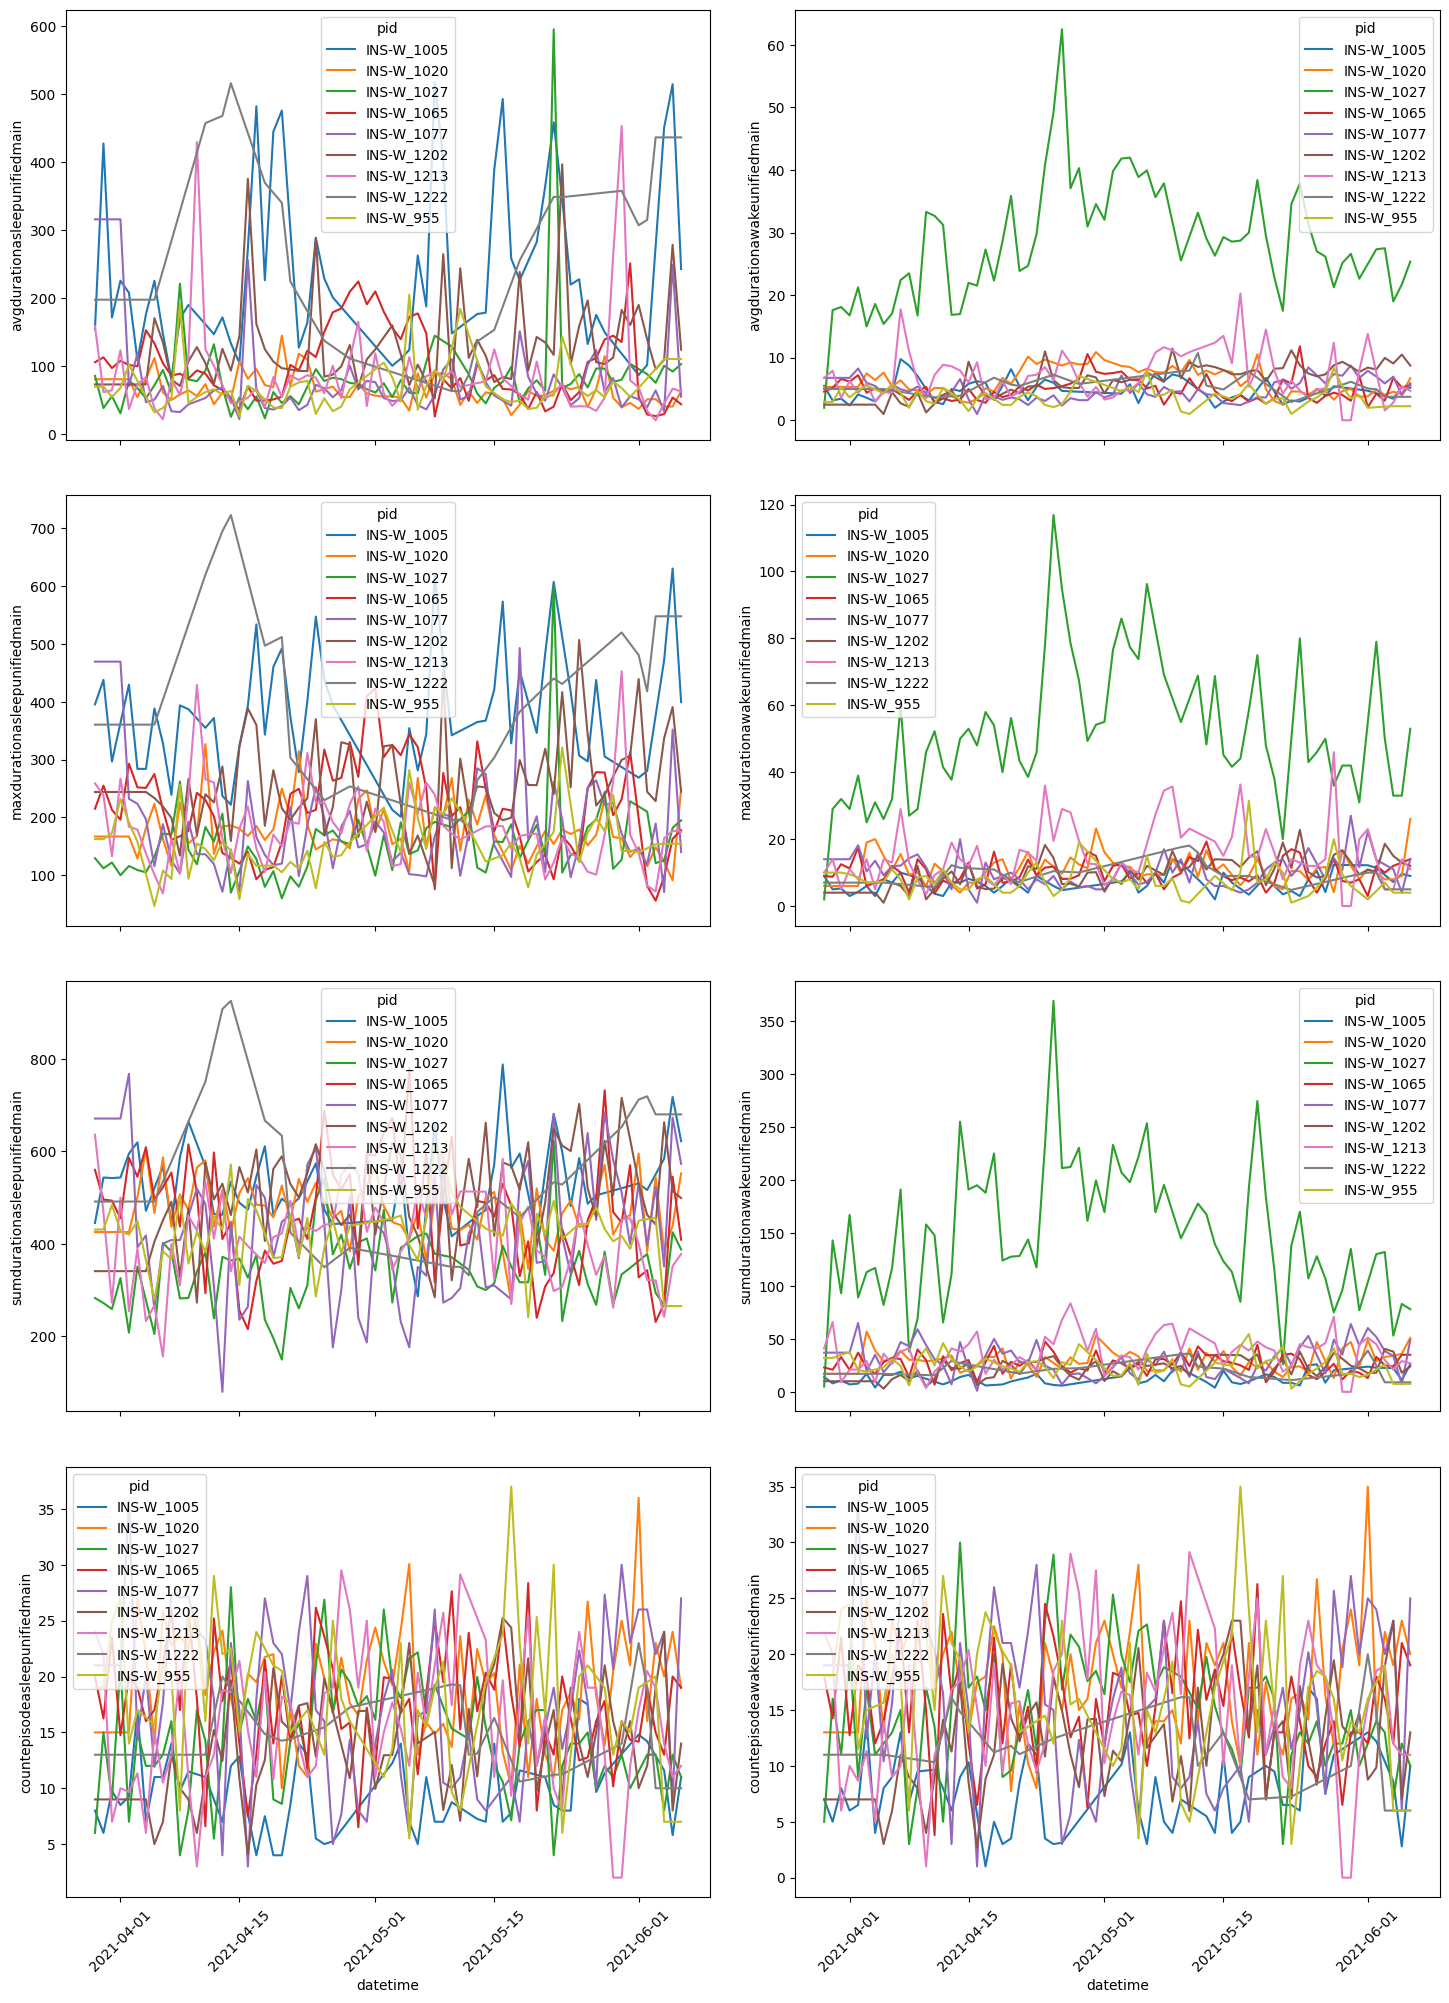

6 ['pid', 'date', 'f_slp:fitbit_sleep_summary_rapids_firstbedtimemain:allday', 'f_slp:fitbit_sleep_summary_rapids_lastbedtimemain:allday', 'f_slp:fitbit_sleep_summary_rapids_firstwaketimemain:allday', 'f_slp:fitbit_sleep_summary_rapids_lastwaketimemain:allday']


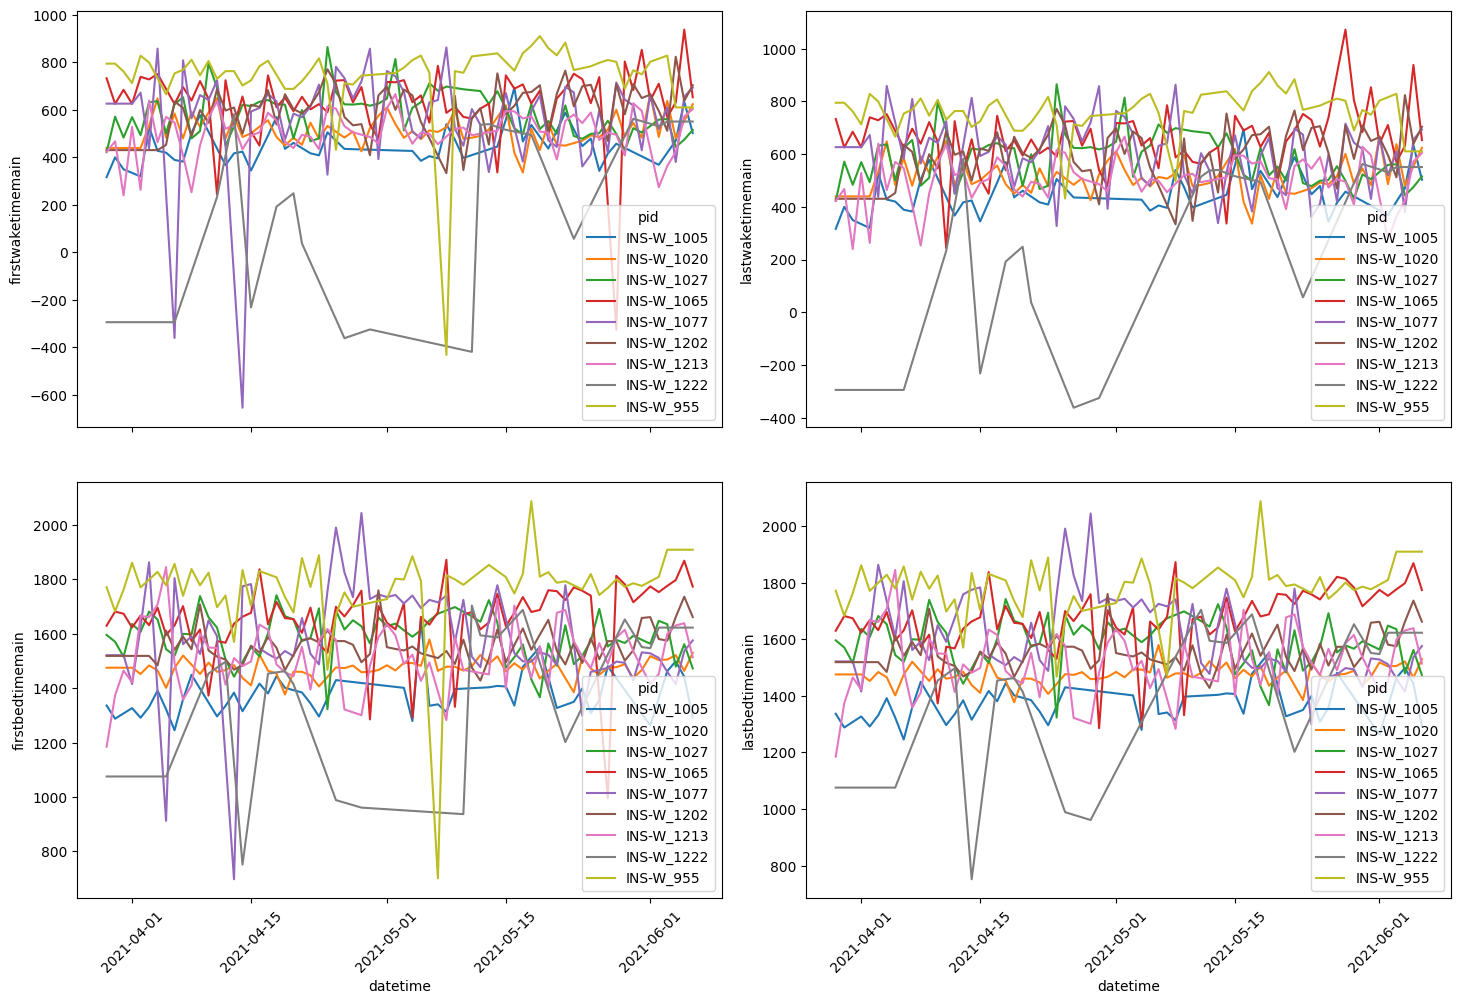

In [18]:
from copy import deepcopy


sleepFeaturesToExtract = [
    "avgdurationasleepunifiedmain",
    "avgdurationawakeunifiedmain",
    "maxdurationasleepunifiedmain",
    "maxdurationawakeunifiedmain",
    "sumdurationasleepunifiedmain",
    "sumdurationawakeunifiedmain",
    "countepisodeasleepunifiedmain",
    "countepisodeawakeunifiedmain",
    # "stddurationasleepunifiedmain",
    # "stddurationawakeunifiedmain",
    # "mindurationasleepunifiedmain",
    # "mindurationawakeunifiedmain",
    # "mediandurationasleepunifiedmain",
    # "mediandurationawakeunifiedmain",
    # "ratiocountasleepunifiedwithinmain",
    # "ratiocountawakeunifiedwithinmain",
    # "ratiodurationasleepunifiedwithinmain",
    # "ratiodurationawakeunifiedwithinmain"
]

allSleepData = PassiveFeatureLoader(
    "4", "sleep", sleepFeaturesToExtract, valid_pids)
plot_feature(allSleepData)
allSleepData.save_data()

featuresDailyExtract = [
    "firstwaketimemain",
    "lastwaketimemain",
    "firstbedtimemain",
    "lastbedtimemain",
]

allSleepDataAllday = PassiveFeatureLoaderAllDay(
    "4", "sleep", featuresDailyExtract, valid_pids)
plot_feature(allSleepDataAllday)
allSleepDataAllday.save_data()

50 ['pid', 'date', 'f_call:phone_calls_rapids_missed_count:afternoon', 'f_call:phone_calls_rapids_missed_distinctcontacts:afternoon', 'f_call:phone_calls_rapids_incoming_count:afternoon', 'f_call:phone_calls_rapids_incoming_distinctcontacts:afternoon', 'f_call:phone_calls_rapids_incoming_meanduration:afternoon', 'f_call:phone_calls_rapids_incoming_sumduration:afternoon', 'f_call:phone_calls_rapids_incoming_countmostfrequentcontact:afternoon', 'f_call:phone_calls_rapids_outgoing_count:afternoon', 'f_call:phone_calls_rapids_outgoing_distinctcontacts:afternoon', 'f_call:phone_calls_rapids_outgoing_meanduration:afternoon', 'f_call:phone_calls_rapids_outgoing_sumduration:afternoon', 'f_call:phone_calls_rapids_outgoing_countmostfrequentcontact:afternoon', 'f_call:phone_calls_rapids_missed_count:evening', 'f_call:phone_calls_rapids_missed_distinctcontacts:evening', 'f_call:phone_calls_rapids_incoming_count:evening', 'f_call:phone_calls_rapids_incoming_distinctcontacts:evening', 'f_call:phone_

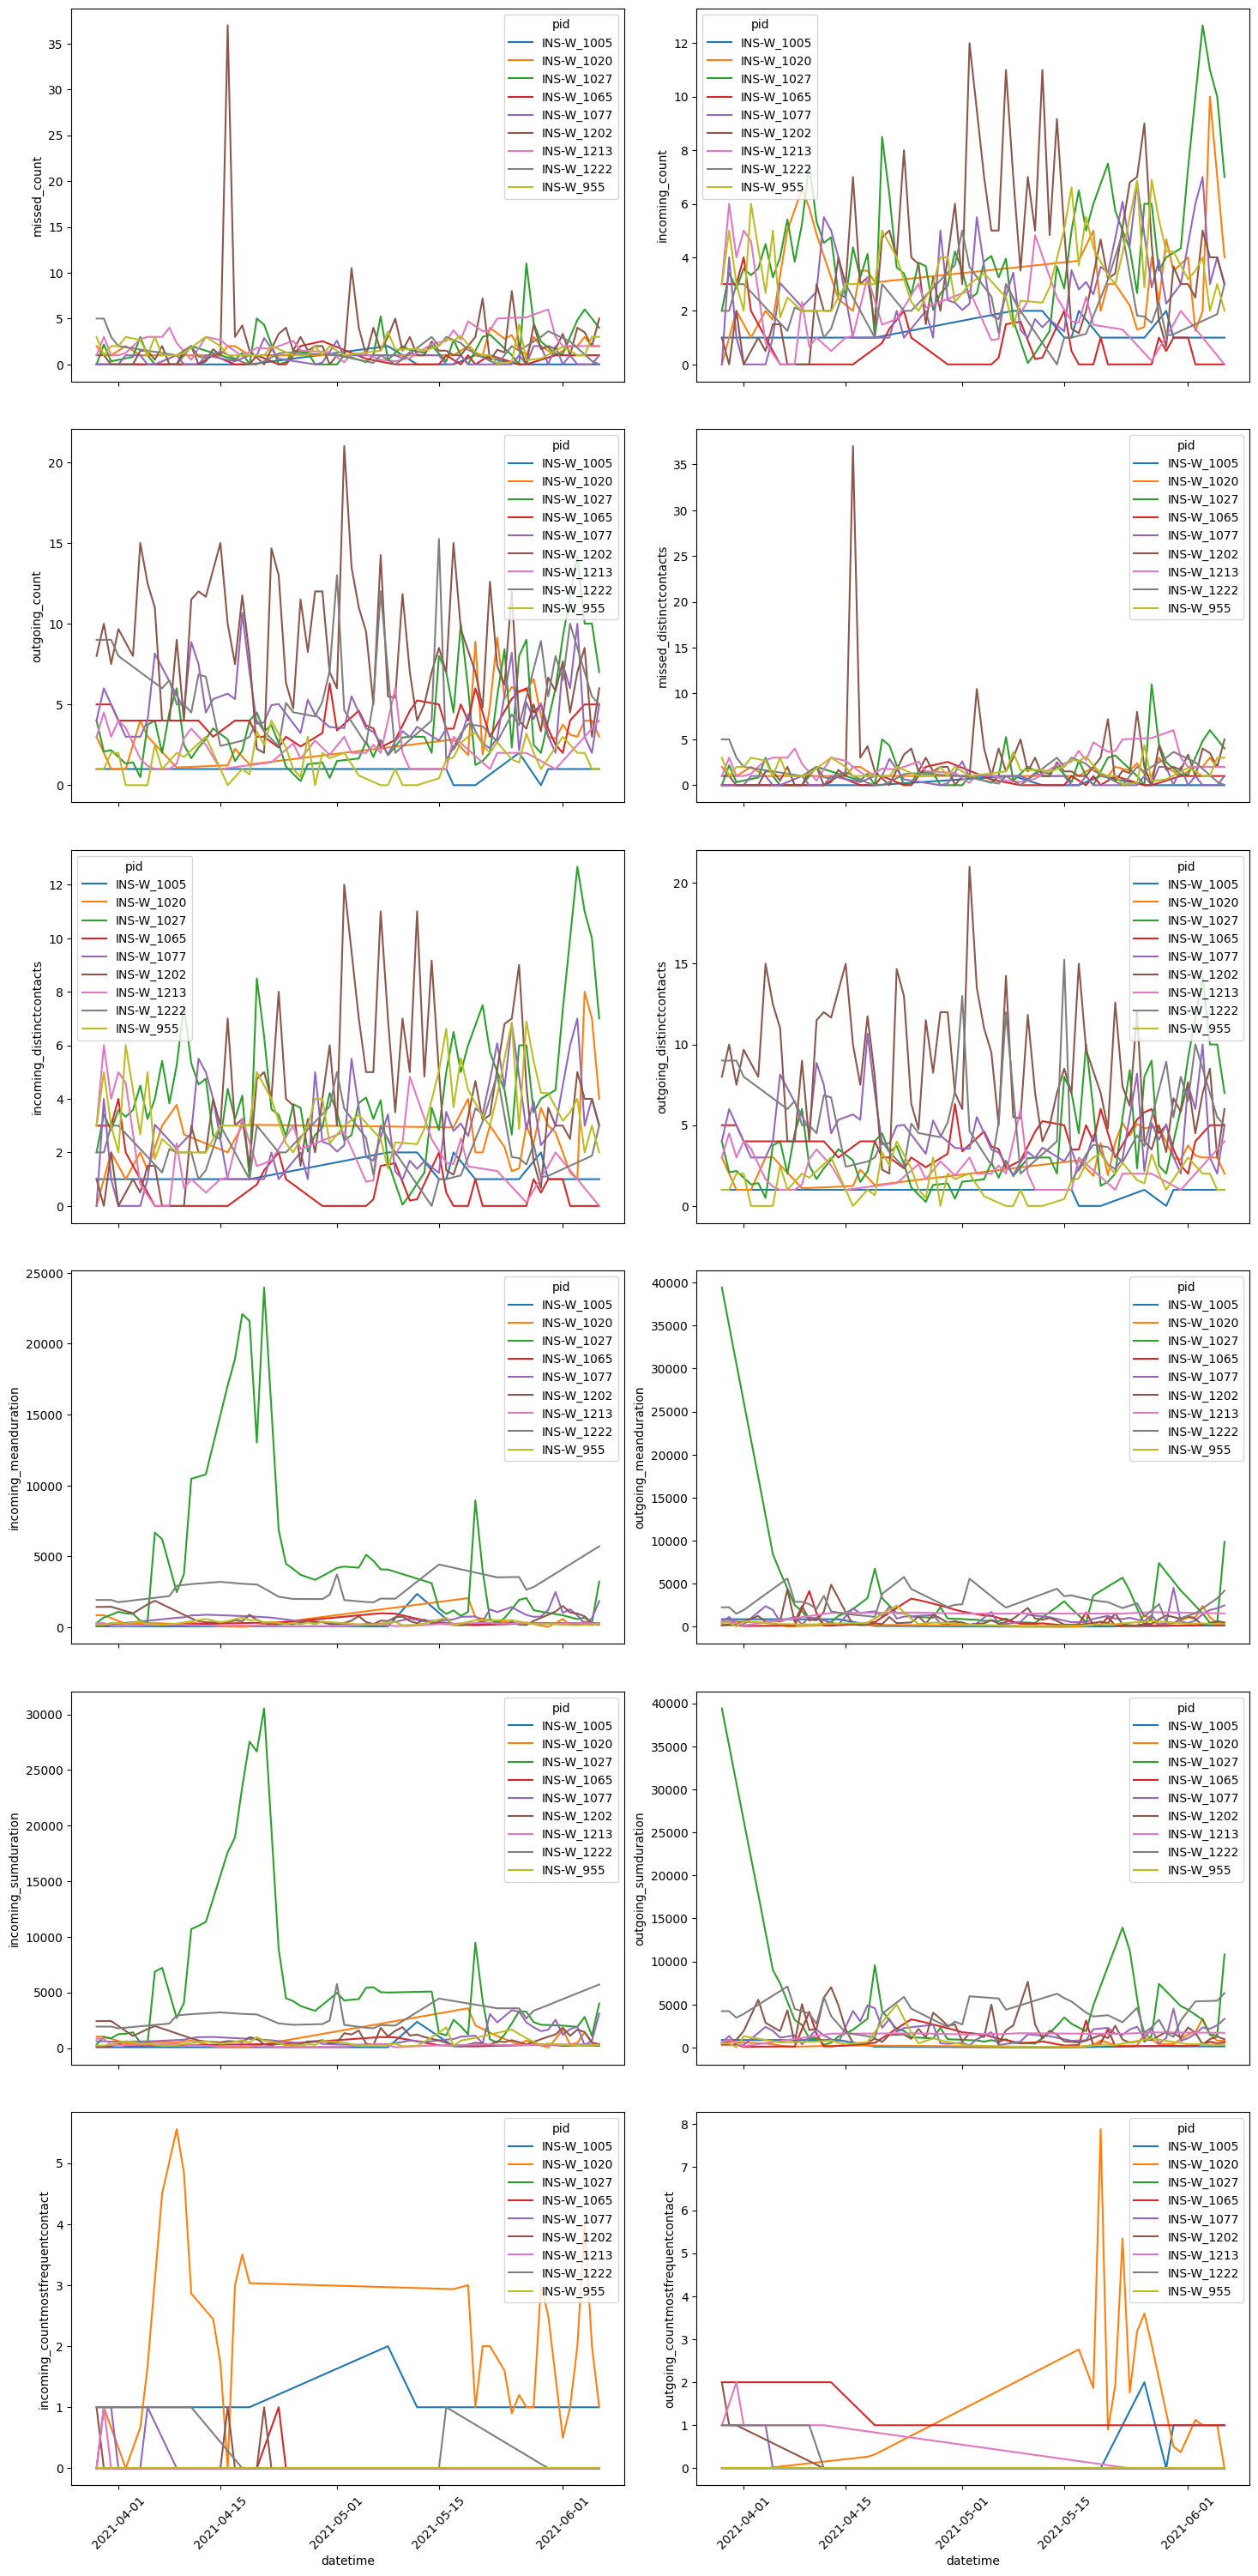

In [19]:
# detailedCallFeaturesToExtract = [
#     "missed_count",
#     "missed_distinctcontacts",
#     "missed_timefirstcall",
#     "missed_timelastcall",
#     "missed_countmostfrequentcontact",
#     "incoming_count",
#     "incoming_distinctcontacts",
#     "incoming_meanduration",
#     "incoming_sumduration",
#     "incoming_minduration",
#     "incoming_maxduration",
#     "incoming_stdduration",
#     "incoming_modeduration",
#     "incoming_entropyduration",
#     "incoming_timefirstcall",
#     "incoming_timelastcall",
#     "incoming_countmostfrequentcontact",
#     "outgoing_count",
#     "outgoing_distinctcontacts",
#     "outgoing_meanduration",
#     "outgoing_sumduration",
#     "outgoing_minduration",
#     "outgoing_maxduration",
#     "outgoing_stdduration",
#     "outgoing_modeduration",
#     "outgoing_entropyduration",
#     "outgoing_timefirstcall",
#     "outgoing_timelastcall",
#     "outgoing_countmostfrequentcontact"
# ]

detailedCallFeaturesToExtract = [
    "missed_count",
    "incoming_count",
    "outgoing_count",

    "missed_distinctcontacts",
    "incoming_distinctcontacts",
    "outgoing_distinctcontacts",

    # "missed_timefirstcall",
    # "missed_timelastcall",
    # "missed_countmostfrequentcontact",

    "incoming_meanduration",
    "outgoing_meanduration",

    "incoming_sumduration",
    "outgoing_sumduration",
    "incoming_countmostfrequentcontact",
    "outgoing_countmostfrequentcontact"

    # "incoming_maxduration",
    # "incoming_entropyduration",
    # "incoming_timefirstcall",
    # "incoming_timelastcall",


    # "outgoing_maxduration",
    # "outgoing_entropyduration",
    # "outgoing_timefirstcall",
    # "outgoing_timelastcall",

]

allDetailedCallData = PassiveFeatureLoader(
    "4", "call", detailedCallFeaturesToExtract, valid_pids)
plot_feature(allDetailedCallData)
allDetailedCallData.save_data()

98 ['pid', 'date', 'f_screen:phone_screen_rapids_countepisodeunlock:afternoon', 'f_screen:phone_screen_rapids_sumdurationunlock:afternoon', 'f_screen:phone_screen_rapids_maxdurationunlock:afternoon', 'f_screen:phone_screen_rapids_avgdurationunlock:afternoon', 'f_screen:phone_screen_rapids_countepisodeunlock_locmap_exercise:afternoon', 'f_screen:phone_screen_rapids_sumdurationunlock_locmap_exercise:afternoon', 'f_screen:phone_screen_rapids_maxdurationunlock_locmap_exercise:afternoon', 'f_screen:phone_screen_rapids_avgdurationunlock_locmap_exercise:afternoon', 'f_screen:phone_screen_rapids_countepisodeunlock_locmap_greens:afternoon', 'f_screen:phone_screen_rapids_sumdurationunlock_locmap_greens:afternoon', 'f_screen:phone_screen_rapids_maxdurationunlock_locmap_greens:afternoon', 'f_screen:phone_screen_rapids_avgdurationunlock_locmap_greens:afternoon', 'f_screen:phone_screen_rapids_countepisodeunlock_locmap_living:afternoon', 'f_screen:phone_screen_rapids_sumdurationunlock_locmap_living:a

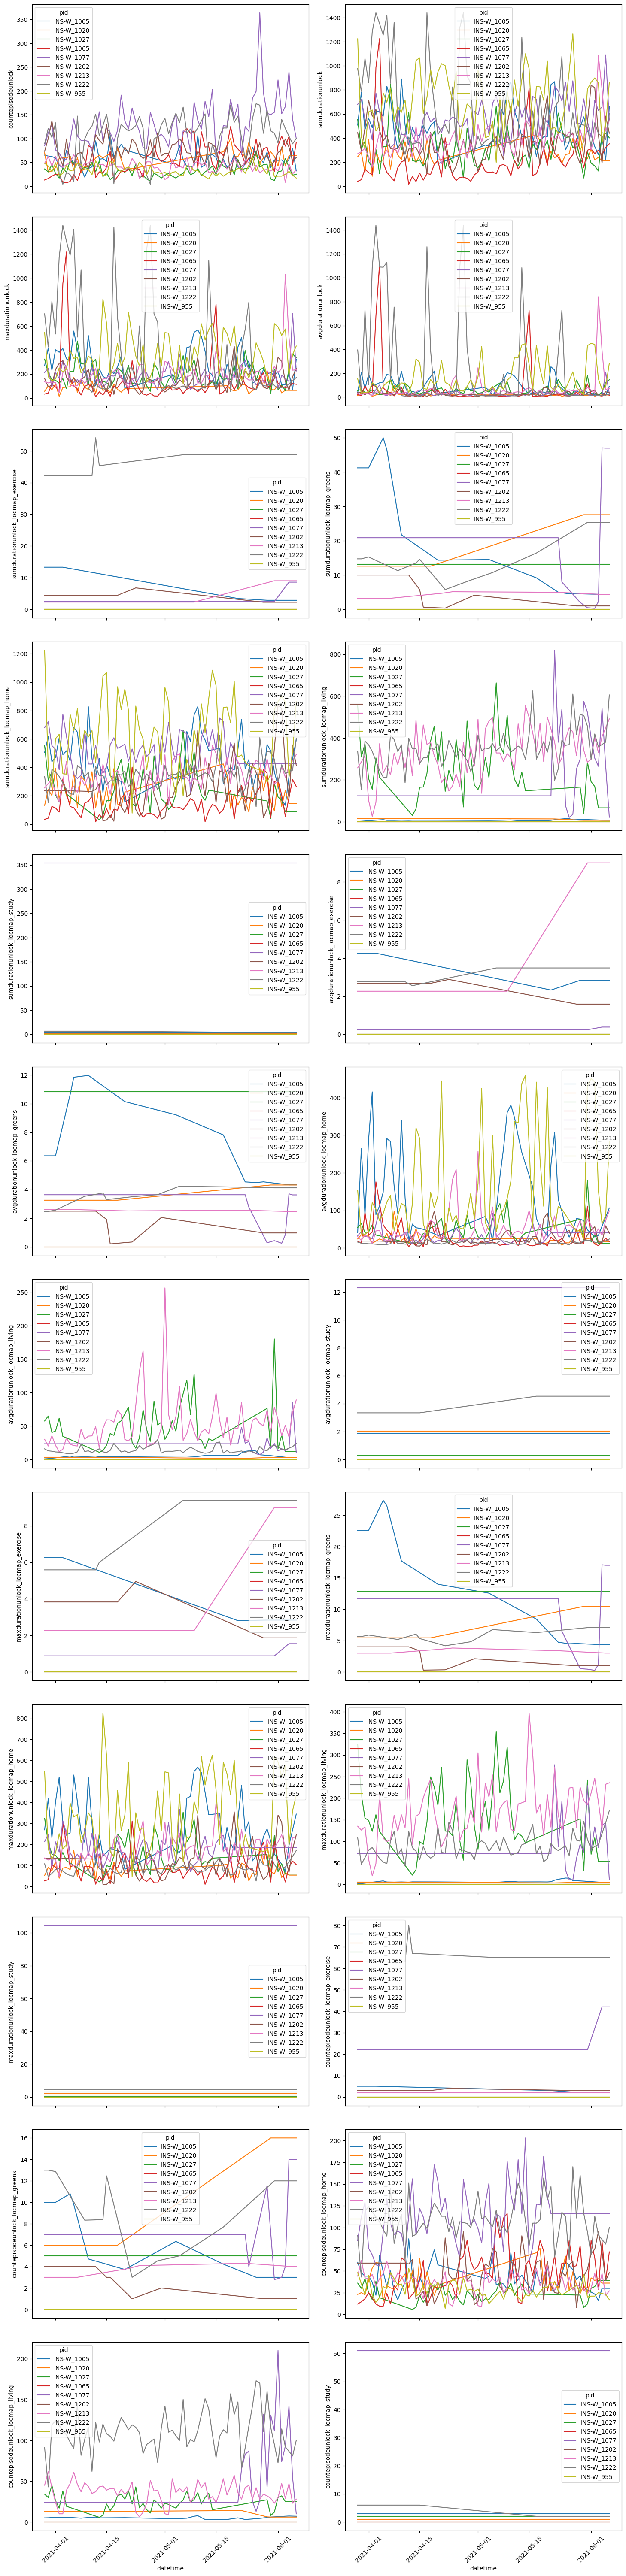

In [16]:
screenTimeFeaturesToExtract = [
    "countepisodeunlock",
    "sumdurationunlock",
    "maxdurationunlock",
    # "mindurationunlock",
    "avgdurationunlock",
    # "stddurationunlock",
    # "firstuseafter00unlock",
    "sumdurationunlock_locmap_exercise",
    "sumdurationunlock_locmap_greens",
    "sumdurationunlock_locmap_home",
    "sumdurationunlock_locmap_living",
    "sumdurationunlock_locmap_study",
    "avgdurationunlock_locmap_exercise",
    "avgdurationunlock_locmap_greens",
    "avgdurationunlock_locmap_home",
    "avgdurationunlock_locmap_living",
    "avgdurationunlock_locmap_study",
    "maxdurationunlock_locmap_exercise",
    "maxdurationunlock_locmap_greens",
    "maxdurationunlock_locmap_home",
    "maxdurationunlock_locmap_living",
    "maxdurationunlock_locmap_study",
    # "mindurationunlock_locmap_exercise",
    # "mindurationunlock_locmap_greens",
    # "mindurationunlock_locmap_home",
    # "mindurationunlock_locmap_living",
    # "mindurationunlock_locmap_study",
    # "stddurationunlock_locmap_exercise",
    # "stddurationunlock_locmap_greens",
    # "stddurationunlock_locmap_home",
    # "stddurationunlock_locmap_living",
    # "stddurationunlock_locmap_study",
    "countepisodeunlock_locmap_exercise",
    "countepisodeunlock_locmap_greens",
    "countepisodeunlock_locmap_home",
    "countepisodeunlock_locmap_living",
    "countepisodeunlock_locmap_study",
    # "firstuseafter00unlock_locmap_exercise",
    # "firstuseafter00unlock_locmap_greens",
    # "firstuseafter00unlock_locmap_home",
    # "firstuseafter00unlock_locmap_living",
    # "firstuseafter00unlock_locmap_study"
]

allScreenTimeData = PassiveFeatureLoader(
    "4", "screen", screenTimeFeaturesToExtract, valid_pids)
plot_feature(allScreenTimeData)
allScreenTimeData.save_data()